## download the data set form this link

https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification/code

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

C:\Users\amrk6\AppData\Local\Temp\ipykernel_12532\940603213.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import pandas as pd
data = pd.read_csv("Data/Training_set.csv")

In [3]:
data.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [4]:
data['path'] = 'Data/train/' + data['filename']
data.head()

,filename,label,path
0,Image_1.jpg,SOUTHERN DOGFACE,Data/train/Image_1.jpg
1,Image_2.jpg,ADONIS,Data/train/Image_2.jpg
2,Image_3.jpg,BROWN SIPROETA,Data/train/Image_3.jpg
3,Image_4.jpg,MONARCH,Data/train/Image_4.jpg
4,Image_5.jpg,GREEN CELLED CATTLEHEART,Data/train/Image_5.jpg


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6499 non-null   object
 1   label     6499 non-null   object
 2   path      6499 non-null   object
dtypes: object(3)
memory usage: 152.4+ KB


In [6]:
class_num = data['label'].nunique()
print("number of unique classes", class_num)

number of unique classes 75


##### more info about seaborn.countplot: https://seaborn.pydata.org/generated/seaborn.countplot.html

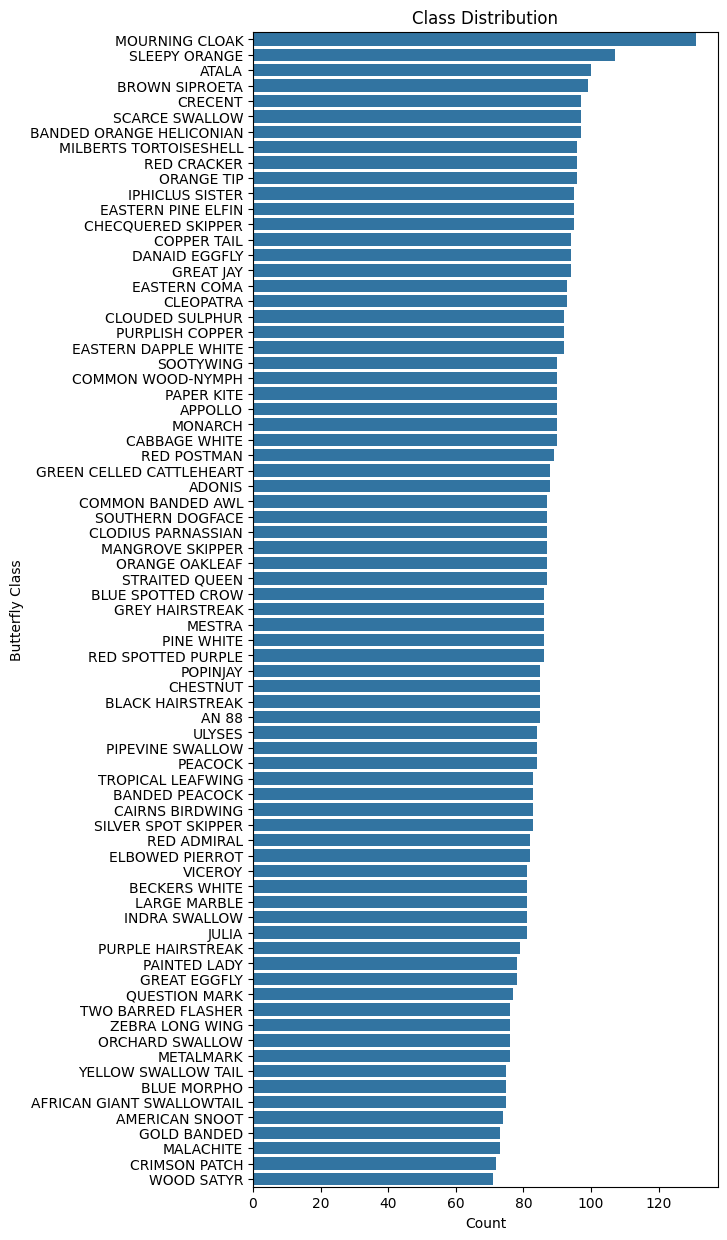

In [7]:
plt.figure(figsize=(6, 15))
sns.countplot(y='label', data=data, order=data['label'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Butterfly Class')
plt.title('Class Distribution')
plt.show()

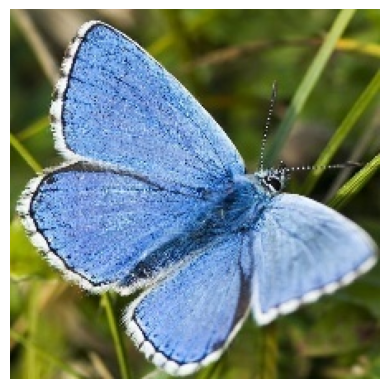

Image shape: (224, 224)
Image mode: RGB


In [8]:
from PIL import Image

def plot_image_from_path(img_path):  #this function plot the image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return img


image_path = data['path'].iloc[1]
image = plot_image_from_path(image_path)

print("Image shape:", image.size)
print("Image mode:", image.mode)

##### split data into training and validation data

In [9]:
train_data, validation_data = train_test_split(data, test_size=0.3, random_state=42)

In [10]:
train_data.head()

,filename,label,path
3758,Image_3759.jpg,BLUE MORPHO,Data/train/Image_3759.jpg
5879,Image_5880.jpg,ULYSES,Data/train/Image_5880.jpg
4907,Image_4908.jpg,BLUE MORPHO,Data/train/Image_4908.jpg
5198,Image_5199.jpg,WOOD SATYR,Data/train/Image_5199.jpg
4733,Image_4734.jpg,EASTERN DAPPLE WHITE,Data/train/Image_4734.jpg


In [11]:
def prep_data(train_data, validation_data, batch_size=16):
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    train_set = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col='path',
        y_col='label',
        target_size=(180, 180),
        batch_size=batch_size,
        class_mode='sparse'
    )

    validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    validation_set = validation_datagen.flow_from_dataframe(
        dataframe=validation_data,
        x_col='path',
        y_col='label',
        target_size=(180, 180),
        batch_size=batch_size,
        class_mode='sparse'
    )

    return train_set, validation_set

train_set, validation_set = prep_data(train_data, validation_data)

Found 4549 validated image filenames belonging to 75 classes.
Found 1950 validated image filenames belonging to 75 classes.


In [12]:
images, labels = next(train_set)

class_names = train_set.class_indices
class_names = {v: k for k, v in class_names.items()}

In [13]:
train_size = train_set.samples
validation_size = validation_set.samples
print(f"Size of training data: {train_size}")
print(f"Size of validation data: {validation_size}")

Size of training data: 4549
Size of validation data: 1950


# The model

###### Image shape: (180, 180, 3) , classNum -> 75
CONV2d (3, 5) -> 

In [14]:
def create_cnn_model(input_shape=(180, 180, 3), num_classes=75):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())


    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


cnn_model = create_cnn_model()

cnn_model.summary()

a:\Pycharm\pycharm\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │        38,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,588,235 (21.32 MB)

 Trainable params: 5,588,235 (21.32 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

In [16]:
history = cnn_model.fit(
    train_set,
    epochs=50,
    validation_data=validation_set,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


a:\Pycharm\pycharm\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


285/285 ━━━━━━━━━━━━━━━━━━━━ 148s 504ms/step - accuracy: 0.0127 - loss: 4.3186 - val_accuracy: 0.0308 - val_loss: 4.0683 - learning_rate: 0.0010
Epoch 2/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 106s 368ms/step - accuracy: 0.0404 - loss: 4.0280 - val_accuracy: 0.0862 - val_loss: 3.7384 - learning_rate: 0.0010
Epoch 3/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 108s 375ms/step - accuracy: 0.0698 - loss: 3.7270 - val_accuracy: 0.2108 - val_loss: 3.0363 - learning_rate: 0.0010
Epoch 4/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 113s 392ms/step - accuracy: 0.1479 - loss: 3.2633 - val_accuracy: 0.2641 - val_loss: 2.8087 - learning_rate: 0.0010
Epoch 5/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 103s 358ms/step - accuracy: 0.1785 - loss: 2.9996 - val_accuracy: 0.3867 - val_loss: 2.3089 - learning_rate: 0.0010
Epoch 6/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 96s 333ms/step - accuracy: 0.2774 - loss: 2.6394 - val_accuracy: 0.4410 - val_loss: 2.0929 - learning_rate: 0.0010
Epoch 7/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 95s 330ms/step - accuracy: 0.3296 - 

In [17]:
history_additional = cnn_model.fit(
    train_set,
    initial_epoch=50, 
    epochs=70,  
    validation_data=validation_set,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 51/70
285/285 ━━━━━━━━━━━━━━━━━━━━ 92s 320ms/step - accuracy: 0.7859 - loss: 0.6878 - val_accuracy: 0.7918 - val_loss: 0.8026 - learning_rate: 1.0000e-05
Epoch 52/70
285/285 ━━━━━━━━━━━━━━━━━━━━ 94s 328ms/step - accuracy: 0.7820 - loss: 0.6696 - val_accuracy: 0.7897 - val_loss: 0.8070 - learning_rate: 1.0000e-05
Epoch 53/70
285/285 ━━━━━━━━━━━━━━━━━━━━ 101s 348ms/step - accuracy: 0.8013 - loss: 0.6408 - val_accuracy: 0.7882 - val_loss: 0.8091 - learning_rate: 1.0000e-05
Epoch 54/70
285/285 ━━━━━━━━━━━━━━━━━━━━ 89s 311ms/step - accuracy: 0.7896 - loss: 0.6753 - val_accuracy: 0.7892 - val_loss: 0.8084 - learning_rate: 1.0000e-05
Epoch 55/70
285/285 ━━━━━━━━━━━━━━━━━━━━ 86s 300ms/step - accuracy: 0.7838 - loss: 0.6790 - val_accuracy: 0.7923 - val_loss: 0.8060 - learning_rate: 1.0000e-05
Epoch 56/70
285/285 ━━━━━━━━━━━━━━━━━━━━ 86s 301ms/step - accuracy: 0.7900 - loss: 0.6913 - val_accuracy: 0.7944 - val_loss: 0.8046 - learning_rate: 1.0000e-05


In [18]:
# Assuming history and history_additional are your initial and additional training histories

history_combined = {}
for key in history.history.keys():
    history_combined[key] = history.history[key] + history_additional.history[key]


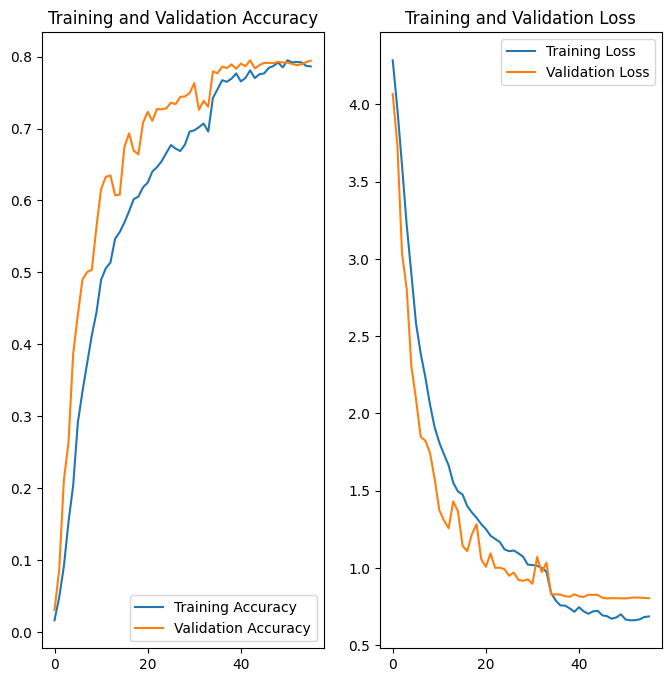

In [19]:
def plot_training_history(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history_combined)

In [20]:
cnn_model.save('model_checkpoint.h5')

In [21]:
'''
from tensorflow.keras.models import load_model

# Load the saved model
cnn_model = load_model('model_checkpoint.h5')

# Continue training from the last epoch
history_additional = cnn_model.fit(
    train_set,
    initial_epoch=last_completed_epoch,  # specify the last completed epoch
    epochs=total_epochs,  # specify the total number of epochs you want to train
    validation_data=validation_set,
    callbacks=[early_stopping, reduce_lr]
)
'''

"\nfrom tensorflow.keras.models import load_model\n\n# Load the saved model\ncnn_model = load_model('model_checkpoint.h5')\n\n# Continue training from the last epoch\nhistory_additional = cnn_model.fit(\n    train_set,\n    initial_epoch=last_completed_epoch,  # specify the last completed epoch\n    epochs=total_epochs,  # specify the total number of epochs you want to train\n    validation_data=validation_set,\n    callbacks=[early_stopping, reduce_lr]\n)\n"

In [22]:
test_data = pd.read_csv("Data/Testing_set.csv")

In [23]:
test_data.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [24]:
test_data['path'] = 'Data/test/' + test_data['filename']
test_data.head()

,filename,path
0,Image_1.jpg,Data/test/Image_1.jpg
1,Image_2.jpg,Data/test/Image_2.jpg
2,Image_3.jpg,Data/test/Image_3.jpg
3,Image_4.jpg,Data/test/Image_4.jpg
4,Image_5.jpg,Data/test/Image_5.jpg


In [25]:
def prep_test_data_unlabeled(test_data, batch_size=16, img_size=(180, 180)):
    test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    
    test_set = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        x_col='path',
        y_col=None,  # No labels
        target_size=img_size,
        batch_size=batch_size,
        class_mode=None,  # No labels
        shuffle=False  # Ensure data is not shuffled for consistent evaluation
    )

    return test_set

# Assuming test_data is a DataFrame with image paths
test_set_unlabeled = prep_test_data_unlabeled(test_data)

# Number of test samples
test_size = test_set_unlabeled.samples
print(f"Size of testing data: {test_size}")


Found 2786 validated image filenames.
Size of testing data: 2786


In [26]:
class_labels = list(train_set.class_indices.keys())

In [27]:
import numpy as np

predictions = cnn_model.predict(test_set_unlabeled)
predicted_classes = np.argmax(predictions, axis=1)


a:\Pycharm\pycharm\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 32s 180ms/step


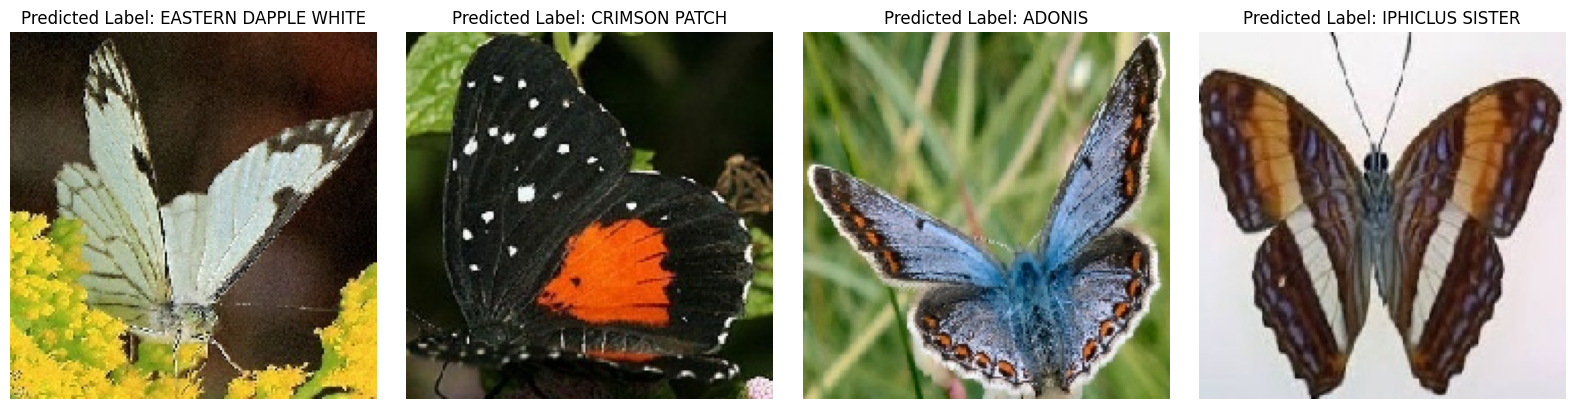

In [38]:
from tensorflow.keras.preprocessing.image import load_img

plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)  # Adjust to 1 row and 4 columns
    img = load_img(test_set_unlabeled.filepaths[i], target_size=(180, 180))
    plt.imshow(img)
    plt.title(f"Predicted Label: {class_labels[predicted_classes[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
